<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/universal_qubit_classifier_using_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Universal Qubit Classifier Using Quantum Gradient Descent**

#### This Notebook's purpose is to introduce machine learning developers or researchers to the Quantum Machine Learning (QML) field. We will implement the following [paper](https://arxiv.org/abs/1907.02085) to show the potential of quantum machine learning



### Important Disclaimer
This notebook is inspired from this [tutorial](https://pennylane.ai/qml/app/tutorial_data_reuploading_classifier.html) except for some changes I have made. 

## **Introduction**

First of all, there is no need to have a solid background in quantum physics to go through this notebook. It would, of course, be helpful but little experience is assumed. However, a solid knowledge of **algebra**, some **calculus**, **trigonometry**, **programming**, and some **machine learning experience** are extremly important.

Throughout the notebook, there will be some reference links that describe some notions or show the origins of a specific assumption. You are advised to follow them if by any chance you feel little uncomfortable with what you read. It's safe to say that in this notebook you may find most of the answers that you are looking for or at least a doorway for them. 


### Environement Setup:
Google Colab does provide everything we need in this tutorial but if you want to try this on your machine then a working version of Python 3.5 or higher would be great. Running the following command line will setup everything for us

> pip install qiskit --upgrade

Some linux machines may require a sudo previlage, so you should pay some intension to that. To make sure everything is working perfect check the output of the following code in a jupyter notebook:

```
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright
```
It should print out the current qiskit version which is 0.11.1 and also the other accompanying libraries. If you want to print out the version in a normal ipython terminal then copy the follwing code:

```
import qiskit
print(qiskit.__version__)
```

Let's first execute the first cell to install the necessary packages on colab.

In [5]:
!pip install qiskit -q --upgrade

import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

By now, you may be wondering about [Qiskit](https://qiskit.org/). Well, it may appear to you as a normal python package that presents some tools for quantum programming. You're not entirely wrong about that. However, it's IBM's main framework for quantum computing. This means that it gives you the required means to control actual quantum computers, calibrate the errors that may occur during executing any circuit, build different quantum algorithms, and of course visualise most of them. It's safe to say that It's a full stack framework where both Hardware and Software quantum developers are working together. You may find all the details you want on their online website.

## **Problem Definition**

The probelm is simply a binary classification task but with a non-linear sepearable dataset. This dataset is chosen to show that the quantum algorithm used for this tutorial is good enough to tackle similar problems easily. The following cell imports the required libraries to plot the dataset.

shape of the training & testing data:  (810, 2) (90, 2)


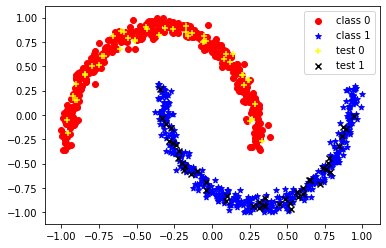

number of samples for testing class_1:  45
number of samples for testing class_0:  45


In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt

n_samples = 900
test_size = 0.1

data,labels = make_moons(n_samples=n_samples,random_state=5,noise=0.04) 

#splitting the data evenly
x_train,x_test,y_train,y_test = train_test_split(data,labels,stratify=labels,test_size=test_size,random_state=0)

#preprocessing
scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

print('shape of the training & testing data: ', x_train.shape, x_test.shape)

#simple plotting
plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', 
            color='red', label='class 0')
plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='*', 
            color='blue', label='class 1')
plt.scatter(x_test[:,0][y_test==0], x_test[:,1][y_test==0], marker='+', 
            color='yellow', label='test 0')
plt.scatter(x_test[:,0][y_test==1], x_test[:,1][y_test==1], marker='x', 
            color='black', label='test 1')

plt.legend()
plt.show()

print("number of samples for testing class_1: ",(y_test==1).sum())
print("number of samples for testing class_0: ",(y_test==0).sum())

The dataset consists of *810* samples for training and *90* samples for testing. They are distributed equally and also scaled between [-1,1]. The typical way to handle such dataset is to use the [Support Vector Machine](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf), [SVM with scikit-learn](https://scikit-learn.org/stable/modules/svm.html), and [SVM with QISKIT](https://iwatobipen.wordpress.com/2019/07/07/svm-on-quantum-computing-quantumcomputing-qiskit/) .

I do urge you to check the first two links if you are not familiar with it. The third link is a direct implementation of quantum SVM algorithm using qiskit-aqua. You may want to check it after finishing this tutorial or if you already familiar with both quantum computing and machine learning then go ahead and open it.

The following code with show you how the svm can solve this problem easily:


In [7]:
from sklearn.svm import SVC
import numpy as np

model = SVC(kernel = 'rbf', gamma = 'scale', C = 1, random_state = 0)

model.fit(x_train,y_train)

print("accuracy of testing is: ", model.score(x_test,y_test))

accuracy of testing is:  1.0


**plotting the decision boundary**


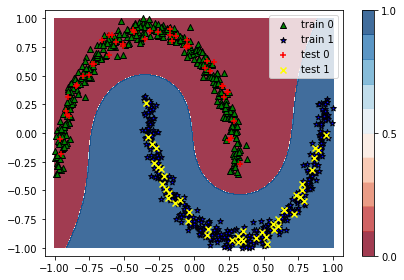

[27 27]


In [8]:
#creating the surface
xx, yy = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
predictions_grid = model.predict(X_grid)
Z = np.reshape(np.array(predictions_grid), xx.shape)

cm = plt.cm.RdBu

cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)

plt.colorbar(cnt, ticks=[0, 0.5, 1])

plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g',
            marker='^', edgecolors='k',label='train 0')
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b',
            marker='*', edgecolors='k',label='train 1')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r',
            marker='+', edgecolors='k',label='test 0')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='yellow',
            marker='x', edgecolors='k',label='test 1')

plt.ylim(-1.07, 1.07)
plt.xlim(-1.07, 1.07)

plt.legend()
plt.tight_layout()
plt.show()
print(model.n_support_)

 **Voila!** you've done it. Then why bother doing the same thing but in a quantum way. You may find some answers to this question but most of them wouldn't be encourging from a business point of view because you already do have an efficient, fast, and clean way. On the other hand, considering real world scenarios, Neural Networks play the most important and vital role in both academia and industry.

The most reasonable answer for this question is a small history lesson. 15 years ago this [paper](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) was the true state of the art, the hype and the coolest thing to use for detecting objects and of course recognising them. It used only a ***Linear Kernel*** for the SVM. After 4 to 5 years GPUs started to be affordable to everyone and this simply led to using them for very complex algebric computations. 

As a natural consequence this [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) by Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton has officially started the deep learning era. However in 1998 this [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner, has actually presented a very promising convolutional neural network for recognising handwritten english numbers aka the mnist dataset. But it was incredibly hard to use this wonderful and novel architecture with the available hardware back then.

In the next 15 to 20 years from now, Quantum Computers would be more powerful, immune to noise, and most importantly essential for us to move on to the next step of solving classically intractable problems as shown in the following figure:

![alt text](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-845-quantum-complexity-theory-fall-2010/6-845f10.jpg) 

It's taken from this great [course form MIT](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-845-quantum-complexity-theory-fall-2010/) about Complexity Theory taughy by Prof. Scott Aaronson. 

Quantum Computation is the natural evolution of the information processing industry and whether you agree or disagree with that it's happening. Let's start introducing some important concepts regarding quantum computing.

## **Quantum Computing Basics**

Information like numbers, voice recordings, or text is encoded into simply *ones* and *zeros*. By combining billions of transistors you can build up different architectures of computers to represent whatever you like. 

From a quantum point of view instead of a "big transistor" that can only produce an on or an off state at a time, a quantum particle like for example an electron can encode 2 classical states the zero and the one.

Let us clarify this mathematically: [bra-ket notation](https://en.wikipedia.org/wiki/Bra%E2%80%93ket_notation)

\begin{align}
  & \left| \psi  \right\rangle =\alpha \left| 0 \right\rangle +\beta \left| 1 \right\rangle \, $ eq(1)\\ & 
  where\,\,  alpha\, \,  and\, \, beta \in \mathbb{C} \\ & {{\alpha }^{2}}+{{\beta }^{2}}=1, \\ 
 & \operatorname{and}\,\left| \, \right\rangle \,,\left\langle  \, \right|\,\text{are}\,\text{called}\,\text{the}\,\text{ket}\,\text{and}\,\text{bra}\,\text{notations} \\ 
\end{align}


The quantum state $\psi$ can be represented by its ground and excited states the zero and the one at the same time. $\alpha$ and $\beta$ are complex numbers and determine the possiblity of each eigen vector. So, the zero and the one are not simply numbers but rather they represent the eigen vectors of the system as follows: 
\begin{align}
\left| 0 \right\rangle =\left[ \begin{matrix}
   1  \\
   0  \\
\end{matrix} \right]
\end{align}

\begin{align}
\left| 1 \right\rangle =\left[ \begin{matrix}
   0  \\
   1  \\
\end{matrix}\right]
\end{align}

eq(1) can be written in a more general form as follows:
\begin{align}
\left| \psi  \right\rangle \,=\,\cos \left( \frac{\theta }{2} \right)\left| 0 \right\rangle \,+\,{{e}^{i\varphi }}\sin \left( \frac{\theta }{2} \right)\left| 1 \right\rangle \ \ \ \ \ \  \ \ \  \ \ \ \  \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \  eq (2) \end{align}

Eq(2) resembles a very famous notation which is the [Bloch Sphere](http://www.vcpc.univie.ac.at/~ian/hotlist/qc/talks/bloch-sphere.pdf), [Bloch Sphere cont](http://www.vcpc.univie.ac.at/~ian/hotlist/qc/talks/bloch-sphere-rotations.pdf). I implore you to check these two links as they build up the first two equations and then explain how can we create any quantum state we want from basic roations as follows:



\begin{align}
  & {{R}_{{\hat{n}}}}\left( \theta  \right)\,=\,\cos \left( \frac{\theta }{2} \right)I\,-\,i\,\sin \left( \frac{\theta }{2} \right)\hat{n}\centerdot \sigma  &         eq(3)\\ \\
 & where\,\,\hat{n}\centerdot \sigma \,=\,\left( {{{\hat{n}}}_{x}}X+\,{{{\hat{n}}}_{y}}Y\,+\,{{{\hat{n}}}_{z}}Z \right) \\ \\ \\
\end{align}




\\begin{align}
  & {{R}_{x}}\left( \theta  \right)={{e}^{-i\frac{\theta X}{2}}}=\cos \left( \frac{\theta }{2} \right)I-i\sin \left( \frac{\theta }{2} \right)X=\left[ \begin{matrix}
   \cos \left( \frac{\theta }{2} \right) & -i\sin \left( \frac{\theta }{2} \right)  \\
   -i\sin \left( \frac{\theta }{2} \right) & \cos \left( \frac{\theta }{2} \right)  \\
\end{matrix} \right]\, \\ 
 & {{R}_{y}}\left( \theta  \right)={{e}^{-i\frac{\theta \text{Y}}{2}}}=\cos \left( \frac{\theta }{2} \right)I-i\sin \left( \frac{\theta }{2} \right)Y=\left[ \begin{matrix}
   \cos \left( \frac{\theta }{2} \right) & -\sin \left( \frac{\theta }{2} \right)  \\
   \sin \left( \frac{\theta }{2} \right) & \cos \left( \frac{\theta }{2} \right)  \\
\end{matrix} \right] & eq(4) \\ 
 & {{R}_{z}}\left( \theta  \right)={{e}^{-i\frac{\theta Z}{2}}}=\cos \left( \frac{\theta }{2} \right)I-i\sin \left( \frac{\theta }{2} \right)Z=\left[ \begin{matrix}
   {{e}^{-i\frac{\theta }{2}}} & 0  \\
   0 & {{e}^{i\frac{\theta }{2}}}  \\
\end{matrix} \right] \\ \\ 
\end{align}


\begin{align}
  & X\,=\,\left[ \begin{matrix}
   0 & 1  \\
   1 & 0  \\
\end{matrix} \right] \\ 
 & Y=\,\left[ \begin{matrix}
   0 & -i  \\
   i & 0  \\
\end{matrix} \right] & \,\,eq(5)\\ 
 & Z=\left[ \begin{matrix}
   1 & 0  \\
   0 & -1  \\
\end{matrix} \right] \\ 
 & I\,=\,\left[ \begin{matrix}
   1 & 0  \\
   0 & 1  \\
\end{matrix} \right] \\ \\\\
\end{align}

\begin{align}
  & X\left| 0 \right\rangle \,=\,\left| 1 \right\rangle ,\,\,\,\,X\left| 1 \right\rangle =\left| 0 \right\rangle  \\ 
 & Y\left| 0 \right\rangle \,=\,i\left| 1 \right\rangle ,\,\,\,Y\left| 1 \right\rangle \,=\,-i\left| 0 \right\rangle  & eq(6)\\ 
 & Z\left| 0 \right\rangle \,=\,\left| 0 \right\rangle ,\,\,\,Z\left| 1 \right\rangle \,=-\left| 1 \right\rangle  \\ \\
\end{align}

Let us break these down one by one:


*   The implicaitons of the first equation are that any quantum state can be in a superposition of two different states, i.e. it might be in 0, or 1 at the same exact time.  

*   $\alpha$ and $\beta$ are complex numbers i.e the space where the quantum state exists is a complex hilbert space and also have length of 1 since the sum of the squares equal 1.

*   Since the length of the quantum state is one we can use discard the $r$ component in the spherical cordinates and focus more on the $\theta$ and $\alpha$ components.

*   This will make it easier to find any arbitrary axis and rotate our quantum state inside the bloch shpere as shown in equation $3$ 

*   If we set $\theta$ to $\pi/2$ equation $5$ will be a special case of $4$ where we defined general rotational Gates that can span the three main axes $X$, $Y$, and $Z$.

*   The following [tool](https://javafxpert.github.io/grok-bloch/?fbclid=IwAR1yC9NJ8ZooQh0zlwGAeChR4l9Xc-WLAvVJf7OhFRMBk8yrX0UoFXvLHOg) will give you a very good intution about what is going on if the maths is annoying.


*   Equation $6$ shows the effet of the basic quantum gates on the eigen vector zero and eigen vector one.



These rotational gates are very important as they enable us to encode our classical data into the quantum states using the free parameters like $\theta$ for example.

There is an important gate called the Rotational gate or $U_3$ where we have three parameters that allow us to encode our classical features in a single qubit.

Let's say we have a vector $x$ that consists of $3$ features like this $x=[x_1,x_2,x_3]$ then $U_3=(\theta,\alpha,\omega)$ will encompase the three features inside each parameter.

In [11]:
x_train[0]

array([0.25867902, 0.20844029])

## Implementing the quantum circuit

The following cell contains a small snipt of code that shows the idea behind the universal qubit classifier. We start by pading the feature vector with zero and then encode it into the $U_3$ gate. we do the same thing for the second qubit. after that we follow it by another rotational gate but its parameters are randomly initialised. these paramterised gates will be optimized later on.

there is somehting called controlled $Z$ gate this is a source of entanglement you can check this amazing [book](https://qiskit.org/textbook/ch-gates/quantum-gates.html) by Qiskit.

this entanglement is not necessary for the sucess of the architecture but i have included it here for the sake of completeness. the controlled $Z$ is repeated $l-1$ where $l$ is the number of repeated layers.

If the feature vector is bigger than three let's say 6 features then 2 $U_3$ gates will be used to encode the feature and then the same thing would happen again.

[ 0.82628941-0.18968241j  0.02537003+0.38744843j -0.0946384 +0.22588754j
 -0.24386265+0.10514692j]


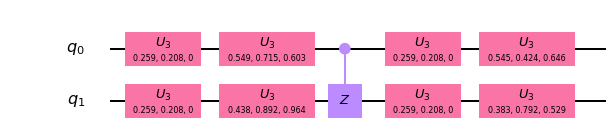

In [24]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *


np.random.seed(0)

weights = np.random.rand(2,2,3)

qc = QuantumCircuit(2)

qc.u3(x_train[0][0],x_train[0][1],0,0)
qc.u3(x_train[0][0],x_train[0][1],0,1)

qc.u3(weights[0][0][0],weights[0][0][1],weights[0][0][2],0)
qc.u3(weights[1][0][0],weights[1][0][1],weights[1][0][2],1)

qc.cz(0,1)

qc.u3(x_train[0][0],x_train[0][1],0,0)
qc.u3(x_train[0][0],x_train[0][1],0,1)

qc.u3(weights[0][1][0],weights[0][1][1],weights[0][1][2],0)
qc.u3(weights[1][1][0],weights[1][1][1],weights[1][1][2],1)

backend_sim = Aer.get_backend('statevector_simulator')

job_sim = execute(qc, backend_sim)

result_sim = job_sim.result()

state_vector = result_sim.get_statevector(qc)
print(state_vector)
qc.draw(output='mpl',scale=0.8)

Since the output from the quantum circuit is simply a vecctor, we can actually assign for each label a vector and then we measure the similarity between them. 

As we only have two labels $0$, and $1$ it would be great to encode these labels in the Zero state and One state as mentioned above and then do somehting called [fidelity measurement](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) where we compute the overlap between the state vector and the other two vectors. 
This can be achieved by $|<1|\psi>|^2$ and $|<0|\psi>|^2$ 

In [29]:
from qiskit.quantum_info import state_fidelity

print('the label of the first sample is: ', y_train[0])

one = np.array([0,0,0,1],dtype='complex')

zero = np.array([1,0,0,0],dtype='complex')

print(state_fidelity(state_vector,one))
print(state_fidelity(state_vector,zero))

the label of the first sample is:  0
0.07052486680732599
0.7187336048871401


The highest the fidelity the better the accuracy and as we can see the label of the first sample is $0$ and its fidelity is the higher.

The output from the quantum circuit is then passed into a log loss function to compute the cost fucntion. this is the only difference between the paper and this tutorial where they defined their cost function to be $1/m\times(1-fidelity_m)$ where $m$ is number of samples 

***The authors of the paper discusses the possibilities of this architecture and its similarities to the classical neural networks in the second section of the paper and proved its universality as a quantum classifier.***

## Code Implementation

This section will contain all the necessary code to implement the paper using qiskit and it.

The code is flexible to implement as many layers as you want with one or two qubits only you are of course welcome to upgrade the code for more qubits as you want.

The fucntion create_data() must be modified if you want increase the number of features or increase the number of labels to more than $3$

In [0]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info.analysis import average_data
from qiskit.quantum_info import state_fidelity
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report
import numpy as np
from tqdm import tqdm 
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt

In [0]:
n_qubits = 1
layers = 6
n_samples = 900

In [0]:
def cerate_data(n_qubits,layers,dataset_name,n_samples,test_size = 0.1,plot=True,normalize=True):

  """
  this fucntion takes 4 main inputs:
  n_qubits: int 1,....,n
  layers: int 1,....,n
  dataset_name: str like 'moons'
  n_samples: int 2,......,n
  test_size: float between 0 and 1

  it returns the training and the testing dataset with their labels and also the 
  corrosponding target states and also the weights for training the classifier
  """

  # creating circles dataset taken from: https://github.com/AdrianPerezSalinas/universal_qlassifier/blob/master/data_gen.py

  def _circle(n_samples):
    centers = np.array([[0, 0]])
    radii = np.array([np.sqrt(1.8/np.pi)])
    data=[]
    dim = 2
    labels=[]
    np.random.seed(1000)
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii):  
            if np.linalg.norm(x - c) < r:
                y = 1 

        data.append(x)
        labels.append(y)
            
    return np.array(data), np.array(labels)

  if dataset_name.lower() == 'moons':
    data,labels = make_moons(n_samples=n_samples,random_state=5,noise=0.04)
  
  if dataset_name.lower() == 'circles':
    data,labels = _circle(n_samples)

  x_train,x_test,y_train,y_test = train_test_split(data,labels,stratify=labels,test_size=test_size,random_state=0) # splitting data evenly

  if normalize: # scale features  [-1:1]

    if len(x_train.shape) == 1: #check for dimension to prevent any error from scaling
      x_train = x_train.reshape(-1,1)
      x_test = x_test.reshape(-1,1)

    scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
    x_train = scale.transform(x_train)
    x_test = scale.transform(x_test)
  
  #check features' dimensions and make it 3 or its multiples
  if len(x_train)<3 or len(x_train) > 6:

    if x_train.shape[1] == 2:

      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1)))

    if x_train.shape[1] == 1:
      
      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1),np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1),np.zeros(len(x_test)).reshape(-1,1)))
    
    if x_train.shape[1] == 4:
      
      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1),np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1),np.zeros(len(x_test)).reshape(-1,1)))

    if x_train.shape[1] == 5:

      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1)))
    if x_train.shape[1] > 6:
      raise ValueError("please create a dataset whose number of features are divisible by 3 as there is no checking mechanisim implemented for values bigger than 6")

  # prepare target states based on number of labels, currently only two-label is implemented

  n_of_labels = len(np.unique(labels))

  state_labels = np.zeros((n_of_labels,2**n_qubits),dtype=np.complex128)

  if n_of_labels == 2:
    state_labels[0,0] = 1
    if n_qubits > 1:
      state_labels[-1] = -1/np.sqrt(2)
    else:
      state_labels[-1,-1] = 1


  # initialize weights  
  np.random.seed(100) #to make results reproducible
  weights = np.random.rand(n_qubits,layers,3)
  
  if plot:
    plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', 
                color='red', label='class 0')
    plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='*', 
                color='blue', label='class 1')
    plt.legend()
    plt.show()

  return (x_train,y_train),(x_test,y_test),state_labels,weights


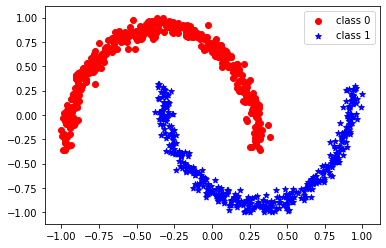

In [50]:
(x_train,y_train),(x_test,y_test),State_labels,params = cerate_data(n_qubits,6,'moons',900,test_size=0.1)

In [51]:
State_labels[0],x_train.shape,params

(array([1.+0.j, 0.+0.j]),
 (810, 3),
 array([[[0.54340494, 0.27836939, 0.42451759],
         [0.84477613, 0.00471886, 0.12156912],
         [0.67074908, 0.82585276, 0.13670659],
         [0.57509333, 0.89132195, 0.20920212],
         [0.18532822, 0.10837689, 0.21969749],
         [0.97862378, 0.81168315, 0.17194101]]]))

state labels are of shape 2 since we have only one qubit state and it's represented by a column vetor of two entries

In [0]:
def circuit(params,X,State_labels=State_labels):

    """

    this function takes 3 inputs:

    params: array like that determines the number of qubits and the number of layers
    X: a single sample that contains the features
    State_labels: are the target states created from create_data()    
    it returns the fidelities from the two target states in a list

    """


    
    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    n_features = len(X)

    for layer in range(layers):
        
        for qubit in range(n_qubits):
           
            for index in range(0,n_features,3):
              qc.u3(X[index],X[index+1],X[index+2],qubit)
              
            qc.u3(params[qubit][layer][0],params[qubit][layer][1],params[qubit][layer][2],qubit)
            
        if n_qubits > 1 and (layer < layers-1):
          qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    state_vector = result_sim.get_statevector(qc)
    fid_1 = state_fidelity(state_vector,State_labels[0])
    fid_2 = state_fidelity(state_vector,State_labels[1])
    #print(average_data(counts,vals))
    return [fid_1,fid_2]

In [0]:
def cost(params,X,y,State_labels):
    """
    params: array like that determines the number of qubits and the number of layers
    
    X: samples that contain the features
    
    y: are the labels for that sample    

    State_labels: are the target states created from create_data()

    this function returns the binary cross entropy cost from the computed fidelities and corresponding labels
    """
    value = []
    
    for i in range(len(X)):
        value.append(circuit(params,X[i],State_labels))

    res = log_loss(y,value,labels=y_train)
   # print(res)
    return res
        

## Quantum Gradients

[Quantum gradients](https://arxiv.org/abs/1811.11184) can be computed by the following equation:

\begin{align}
  \frac{df}{d\theta }\,=\,\frac{1}{2}\,\left( f\left( x,\theta +\frac{\pi }{2} \right)-f\left( x,\theta -\frac{\pi }{2} \right) \right)\\ \\
\end{align}

where $x$ is the input data, $\theta$ is the weights and $f$ is quantum unitary gate. 



In [0]:
def gradient(params,x,y,State_labels):
    """
    this function computes the gradients for each varaible in the quantum circuit
    it takes:
    x: a single sample
    y: the corresponding label
    State_labels: are the target states created from create_data()
    """
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [0]:
def optimize(params,X,y,lr,State_labels):
    """

    this fucntion controls SGD by computing the gradients and updating the weights

    """
    g = gradient(params,X,y,State_labels)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [0]:
def predict(params,X):

    """
    this function takes only the weights "params" and a single sample from the data

    it returns a continous output ranging from 0 to 1. this requires rounding the output

    """

    fid_1,fid_2 = circuit(params,X)


    if fid_1 > fid_2:
      
      return abs(1-fid_1)
    
    else:

      return fid_2
    

I have saved you the time and the following are the weights and the testing

In [0]:
best_weights = np.array([[[ 1.13449496,  0.28881491,  1.41365572],
        [ 1.04005053,  1.11646599, -1.71870497],
        [ 0.23246252, -0.40714122,  0.48893466],
        [ 1.21158487,  0.71205549, -0.76677812],
        [ 2.46779094, -0.92909167, -0.34517346],
        [-0.45782809,  0.81168315, -0.0658338 ]]])

pred = []

for j in range(len(x_test)):
    pred.append(predict(best_weights,x_test[j]))

In [65]:
print(accuracy_score(np.array(pred).round(),y_test))
print(classification_report(np.array(pred).round(),y_test))

1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



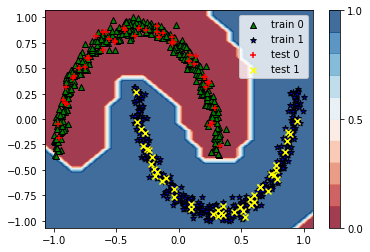

In [63]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 50), np.linspace(-2, 2, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
X_grid = np.hstack((X_grid,np.zeros(len(X_grid)).reshape(-1,1)))
predictions_grid = [predict(best_weights, x) for x in X_grid]

Z = np.reshape(np.array(predictions_grid).round(), xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)

plt.colorbar(cnt, ticks=[0, 0.5, 1])
plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g', marker='^', edgecolors='k',label='train 0')
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b', marker='*', edgecolors='k',label='train 1')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r', marker='+', edgecolors='k',label='test 0')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='yellow', marker='x', edgecolors='k',label='test 1')

plt.ylim(-1.07, 1.07)
plt.xlim(-1.07, 1.07)
plt.legend()
plt.show()


This the following cell of course gives you the pleasure of waiting till tyou train the network

In [0]:
np.random.seed(100) #to be reproducible 
#params = np.random.rand(1,6,3)
weights = params
loss = np.inf
lr = 0.22
test_loss = []
epochs = 500
batch_size = 20

for it in range(epochs):


    # create random indices every iteration "stochastic gradient descent way not mini batch because of long time" 
    index = np.random.randint(0,len(x_train),batch_size)
    x_batch,y_batch = x_train[index],y_train[index]
    # if you want to decay lr uncomment the following and edit it the way you want 
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr,State_labels)
    
    res = cost(weights,x_test,y_test,State_labels)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

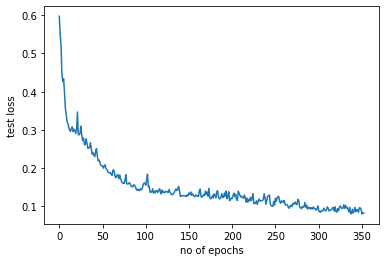

In [0]:
plt.xlabel('no of epochs')
plt.ylabel('test loss')
plt.plot(range(len(test_loss)),test_loss)
plt.show()